In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d subirbiswas19/skin-disease-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/skin-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subirbiswas19/skin-disease-dataset
License(s): CC0-1.0
 40% 7.00M/17.3M [00:00<00:00, 33.0MB/s]
100% 17.3M/17.3M [00:00<00:00, 66.4MB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:

# Load dataset for multi-class classification
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/skin-disease-datasaet/train_set',
    labels='inferred',
    label_mode='int',  # For multi-class, use integer labels
    batch_size=32,
    image_size=(256, 256)
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/skin-disease-datasaet/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 924 files belonging to 8 classes.
Found 233 files belonging to 8 classes.


In [ ]:
# Define an enhanced CNN model for multi-class classification
num_classes = 8  # Change this number based on the number of diseases to classify

model = Sequential()

In [ ]:

# Input layer
model.add(Input(shape=(256, 256, 3)))  # Input shape for images

# Convolutional layers with BatchNormalization, Dropout, and LeakyReLU for better performance
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense layers with Dropout for regularization
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(Dropout(0.5))

In [ ]:
# Output layer for multi-class classification with 'softmax'
model.add(Dense(num_classes, activation='softmax'))  # num_classes represents the number of diseases

# Compile the model with sparse categorical cross-entropy for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Learning rate scheduler to gradually decrease the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
         return float(lr * tf.math.exp(-0.1).numpy())

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:

# Train the model
history = model.fit(train_ds, epochs=5, validation_data=validation_ds, callbacks=[early_stopping, lr_scheduler])

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 706ms/step - accuracy: 0.2964 - loss: 2.3112 - val_accuracy: 0.2575 - val_loss: 13.9141 - learning_rate: 0.0010
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5123 - loss: 1.3249 - val_accuracy: 0.2790 - val_loss: 7.1599 - learning_rate: 0.0010
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.6574 - loss: 0.9938 - val_accuracy: 0.3863 - val_loss: 3.0202 - learning_rate: 0.0010
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.7434 - loss: 0.7528 - val_accuracy: 0.3906 - val_loss: 3.7316 - learning_rate: 0.0010
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8113 - loss: 0.5334 - val_accuracy: 0.5536 - val_loss: 1.6751 - learning_rate: 0.0010


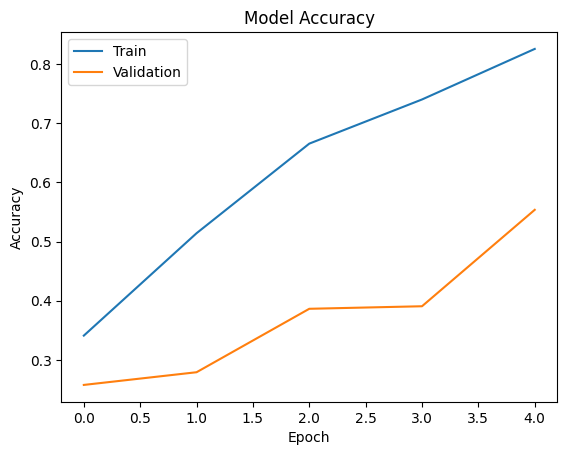

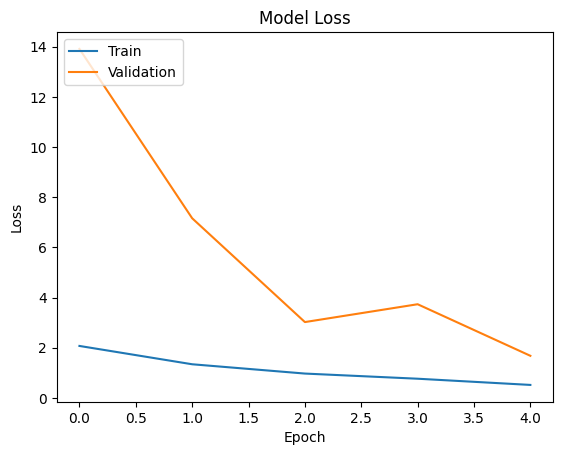

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')  # 'Validation' should be a string
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')  # 'Validation' should be a string
plt.show()


In [ ]:
# Multi-Class Prediction on a New Image
def predict_image(image_path):
    # Load and preprocess the image
    test_image = cv2.imread(image_path)

    if test_image is None:
        print("Error: Image not loaded, check if the file path is correct.")
        return

    # Resize the image to match the input size of the model
    test_image = cv2.resize(test_image, (256, 256))
    test_image = test_image / 255.0  # Normalize image
    test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(test_image)

    # Convert prediction to the most likely class
    predicted_class = tf.argmax(prediction[0])

    # Assuming there are 5 diseases (replace with actual disease names)
    disease_names = ['Chickenpox', 'Eczema', 'Ringworm', 'Disease4', 'Disease5','Chickenpox', 'Eczema', 'Ringworm']

    print("Predicted Disease:", disease_names[predicted_class])

    # Display the image with predicted label
    plt.imshow(cv2.cvtColor(test_image[0], cv2.COLOR_BGR2RGB))
    plt.title(f'Prediction: {disease_names[predicted_class]}')
    plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_image(image_path):
    # Load and preprocess the image
    test_image = cv2.imread(image_path)

    if test_image is None:
        print("Error: Image not loaded, check if the file path is correct.")
        return

    # Resize the image to match the input size of the model
    test_image = cv2.resize(test_image, (256, 256))
    test_image_normalized = test_image / 255.0  # Normalize image
    test_image_normalized = tf.expand_dims(test_image_normalized, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(test_image_normalized)

    # Convert prediction to the most likely class
    predicted_class = tf.argmax(prediction[0])

    # Assuming there are 5 diseases (replace with actual disease names)
    disease_names = ['Chickenpox', 'Eczema', 'Ringworm', 'Disease4', 'Disease5','Disease6', 'Disease7', 'Chickenpox', 'Disease9']

    print("Predicted Disease:", disease_names[predicted_class])

    # Display the original image with the predicted label
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Using original test_image
    plt.title(f'Prediction: {disease_names[predicted_class]}')
    plt.show()

# Example usage of the prediction function
test_image_path = '/content/varicdc015.jpg'  # Provide the correct image path
predict_image(test_image_path)


Error: Image not loaded, check if the file path is correct.


In [ ]:
# model.save('/content/model_savv.keras')


In [ ]:

# from google.colab import files

# !zip -r model_savv.zip model_savv.keras
# files.download('model_savv.zip')




In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Save the zip file to Google Drive
!cp model_savv.zip /content/drive/MyDrive/


Mounted at /content/drive
cp: cannot stat 'model_savv.zip': No such file or directory
